<a href="https://colab.research.google.com/github/JoshStrong/Character-RNN/blob/main/Character_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sequence prediction ##
A language model, predicts the next output in a sequence given a number of initial observations.
Recurrent neural networks have been popular for language modelling for some time and for this
task and we will use one to predict the next character in order to keep the output space significantly
smaller than if we were to predict the next word.
This project:
1. Implements a character-level recurrent neural network model with a cross-entropy loss for
the textual portion of the Stanford Sentiment Treebank data, where the model is to predict
the next character based on the character previously observed for a given sentence.
2. Explores model variants with different recurrent units (“vanilla”, LSTM, and GRU), number
of layers, different depths and layer sizes for the multi-layer perceptron, etc. to find what
works well on the validation set, describing the process through which I arrived at my
final model.
3. Trains a final model to convergence on the training set.
4. Provides a plot of the loss on the training set and validation set for each epoch of training.
5. Provides the final accuracy on the training, validation, and test set.
6. Provide 5 sentences completed by your final model, after I have provided a first few
words.


## Julia on Colaboratory ##

[Colaboratory](https://colab.research.google.com) does not provide native support for the [Julia programming language](https://julialang.org). However, since Colaboratory gives you root access to the machine that runs your notebook (the *“runtime”* in Colaboratory terminology), we can install Julia support by uploading a specially crafted Julia notebook  – *this* notebook. We then install Julia and [IJulia](https://github.com/JuliaLang/IJulia.jl) ([Jupyter](https://jupyter.org)/Colaboratory notebook support) and reload the notebook so that Colaboratory detects and initiates what we installed.

In brief:

1. **Run the cell below**
2. **Reload the page**
3. **Edit the notebook name and start hacking Julia code below**

**If your runtime resets**, either manually or if left idle for some time, **repeat steps 1 and 2**.

### Acknowledgements ###

This hack by Pontus Stenetorp is an adaptation of [James Bradbury’s original Colaboratory Julia hack](https://discourse.julialang.org/t/julia-on-google-colab-free-gpu-accelerated-shareable-notebooks/15319/27), that broke some time in September 2019 as Colaboratory increased their level of notebook runtime isolation. There also appears to be CUDA compilation support installed by default for each notebook runtime type in October 2019, which shaves off a good 15 minutes or so from the original hack’s installation time.

In [ ]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

In [ ]:
using Pkg

Pkg.add(Pkg.PackageSpec(;name="CuArrays", version=v"1.3.0"))
Pkg.add(Pkg.PackageSpec(;name="Flux", version=v"0.9.0"))
Pkg.add("CUDAdrv")

pkg"add Plots"
pkg"add StatsBase"

pkg"precompile"

In [ ]:
using CuArrays
using Flux
using Flux: onehot, chunk, batchseq, throttle, crossentropy
using StatsBase: wsample
using CUDAdrv

using Base.Iterators: partition
using LinearAlgebra
using Random
using Statistics
using Plots

In [ ]:
# Check google colab GPU assignment
CUDAdrv.name(CuDevice(0))

"Tesla P4"

# Data Loading & Preparation: Stanford Sentient Treebank Data

In [ ]:
run(`curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip`)
run(`unzip -q -o -d /tmp /tmp/trainDevTestTrees_PTB.zip`)
run(`rm -f /tmp/trainDevTestTrees_PTB.zip`)

nothing

In [ ]:
function loadsst(path)
    xs = Array{String}[]
    ys = Int[]
    open(path) do file
        # Quick, dirty, and improper S-expression parsing.
        for line in eachline(file)
            soup = split(line)
            push!(ys, parse(Int, lstrip(first(soup), '(')))
            tokens = String[]
            for chunk in soup[2:end]
                endswith(chunk, ")") || continue
                push!(tokens, rstrip(chunk, ')'))
            end
            push!(xs, tokens)
        end
    end
    xs, ys
end

ssttrainxs, ssttrainys = loadsst("/tmp/trees/train.txt")
sstvalidxs, sstvalidys = loadsst("/tmp/trees/dev.txt")
ssttestxs, ssttestys   = loadsst("/tmp/trees/test.txt")

nothing

In [ ]:
for _ in 1:32
    i = rand(1:length(ssttrainxs))
    println("$(ssttrainys[i]): $(join(ssttrainxs[i], ' '))")
end

2: While certain cues , like the happy music , suggest that this movie is supposed to warm our hearts , Jeong-Hyang Lee 's film is just as likely to blacken that organ with cold vengefulness .
3: What 's not to like about a movie with a ` children 's ' song that includes the line ` My stepdad 's not mean , he 's just adjusting ' ?
3: This is a dark , gritty , sometimes funny little gem .
1: The holes in this film remain agape -- holes punched through by an inconsistent , meandering , and sometimes dry plot .
4: Director Lee has a true cinematic knack , but it 's also nice to see a movie with its heart so thoroughly , unabashedly on its sleeve .
2: You can thank me for this .
3: But though he only scratches the surface , at least he provides a strong itch to explore more .
1: Yet another genre exercise , Gangster No. 1 is as generic as its title .
3: A keep - 'em - guessing plot and an affectionate take on its screwed-up characters .
2: The Grey Zone gives voice to a story that needs to

In [ ]:
println(ssttrainxs[1])
print(length(ssttrainxs), " training sentances")

["The", "Rock", "is", "destined", "to", "be", "the", "21st", "Century", "'s", "new", "``", "Conan", "''", "and", "that", "he", "'s", "going", "to", "make", "a", "splash", "even", "greater", "than", "Arnold", "Schwarzenegger", ",", "Jean-Claud", "Van", "Damme", "or", "Steven", "Segal", "."]
8544 training sentances

In [ ]:
# Use join function to concatonate text to a similar format as seen in lecture 15
# Repeat for training, testing & validation data
# Remove characters from validation & testing data which aren't seen in the training data
text_train = []
text_valid = []
text_test  = []

for i = 1:length(ssttrainxs)
    append!(text_train, join(ssttrainxs[i], ' '))
end

for i = 1:length(sstvalidxs)
    append!(text_valid, join(sstvalidxs[i], ' '))
end
filter!(x -> x ∉ ('à','ö','%'), text_valid)

for i = 1:length(ssttestxs)
    append!(text_test, join(ssttestxs[i], ' '))
end
filter!(x -> x ∉ ('û'), text_test);

In [ ]:
@show length(text_train) sort(unique(text_train)) length(sort(unique(text_train)));

length(text_train) = 877082
sort(unique(text_train)) = Any[' ', '!', '#', '$', '&', '\'', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'á', 'â', 'ã', 'æ', 'ç', 'è', 'é', 'í', 'ï', 'ñ', 'ó', 'ô', 'ü']
length(sort(unique(text_train))) = 93


In [ ]:
@show length(text_test) sort(unique(text_test)) length(sort(unique(text_test)));

length(text_test) = 226991
sort(unique(text_test)) = Any[' ', '!', '$', '&', '\'', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'è', 'é', 'í', 'ó', 'ü']
length(sort(unique(text_test))) = 82


In [ ]:
@show length(text_valid) sort(unique(text_valid)) length(sort(unique(text_valid)));

length(text_valid) = 113926
sort(unique(text_valid)) = Any[' ', '!', '$', '\'', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'æ', 'é']
length(sort(unique(text_valid))) = 78


In [ ]:
# Create a stop character to allow the network to identify the end of a sequence
stopchar = '_'
@assert !(stopchar in unique(text_train))
outputs = [stopchar, unique(text_train)...]
sort!(outputs)

nothing

In [ ]:
# Encode the training, testing & validation data
# Convert each character of the text into a one-hot vector of the unique elements of the training data
enctext_train = map(c -> onehot(c, outputs), text_train)
enctext_test  = map(c -> onehot(c, outputs), text_test)
enctext_valid = map(c -> onehot(c, outputs), text_valid)

encstop = onehot(stopchar, outputs);

In [ ]:
maxinputlen = 50 
numbatches  = 50

# Create training, testing & validation data
trainxs = collect(partition(batchseq(chunk(enctext_train, numbatches), encstop), maxinputlen))
trainys = collect(partition(batchseq(chunk(enctext_train[2:end], numbatches), encstop), maxinputlen))

testxs  = collect(partition(batchseq(chunk(enctext_test, numbatches), encstop), maxinputlen))
testys  = collect(partition(batchseq(chunk(enctext_test[2:end], numbatches), encstop), maxinputlen))

validxs = collect(partition(batchseq(chunk(enctext_valid, numbatches), encstop), maxinputlen))
validys = collect(partition(batchseq(chunk(enctext_valid[2:end], numbatches), encstop), maxinputlen))

nothing

### 1: Implement a character-level recurrent neural network model with a cross-entropy loss for the textual portion of the Stanford Sentiment Treebank data, where the model is to predict the next character based on the character previously observed for a given sentence.

In [ ]:
# The most basic recurrent layer; essentially acts as a Dense layer, but with the output fed back into the input each time step.
# Stacked basic recurrent units, to gain better loss:
# See https://fluxml.ai/Flux.jl/v0.5/models/layers.html

RNN_model = Chain(
    RNN(length(outputs), 128),
    RNN(128, 128),
    Dense(128, length(outputs)),
    softmax) |> gpu

function loss(xs, ys)
    l = mean(crossentropy.(RNN_model.(gpu.(xs)), gpu.(ys)))
    Flux.truncate!(RNN_model)
    l
end

optimiser = ADAM(0.001)

nothing

┌ Info: Building the CUDAnative run-time library for your sm_61 device, this might take a while...
└ @ CUDAnative /root/.julia/packages/CUDAnative/Lr0yj/src/compiler/rtlib.jl:173


In [ ]:
loss_train = []
loss_valid = []

# Train the model for 20 epochs
@time for epoch in 1:20
    @time Flux.train!(loss, params(RNN_model), zip(trainxs, trainys), optimiser)
    append!(loss_train, loss(trainxs[1], trainys[1]).data)
    append!(loss_valid, loss(validxs[1], validys[1]).data)
    println("Epoch $epoch: \t Training loss: \t $(loss(trainxs[1], trainys[1]).data)")
    flush(stdout)
end

 91.830643 seconds (139.77 M allocations: 7.442 GiB, 6.19% gc time)
Epoch 1: 	 Training loss: 	 2.1563451
 52.263512 seconds (76.35 M allocations: 4.228 GiB, 5.13% gc time)
Epoch 2: 	 Training loss: 	 1.9730382
 51.671313 seconds (76.36 M allocations: 4.229 GiB, 4.41% gc time)
Epoch 3: 	 Training loss: 	 1.8642623
 51.725236 seconds (76.36 M allocations: 4.229 GiB, 4.40% gc time)
Epoch 4: 	 Training loss: 	 1.7900156
 52.230423 seconds (76.36 M allocations: 4.229 GiB, 4.88% gc time)
Epoch 5: 	 Training loss: 	 1.7354428
 51.916780 seconds (76.36 M allocations: 4.228 GiB, 4.42% gc time)
Epoch 6: 	 Training loss: 	 1.6944318
 52.243947 seconds (76.36 M allocations: 4.229 GiB, 4.89% gc time)
Epoch 7: 	 Training loss: 	 1.6620624
 51.959257 seconds (76.36 M allocations: 4.229 GiB, 4.38% gc time)
Epoch 8: 	 Training loss: 	 1.6360087
 52.105060 seconds (76.36 M allocations: 4.229 GiB, 4.89% gc time)
Epoch 9: 	 Training loss: 	 1.6143123
 51.834677 seconds (76.36 M allocations: 4.229 GiB, 4.

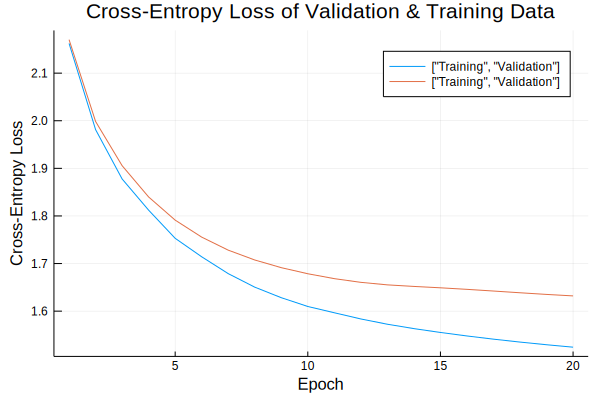

In [ ]:
plot([loss_train,loss_valid], label=["Training","Validation"], xlab="Epoch", ylab="Cross-Entropy Loss", title="Cross-Entropy Loss of Validation & Training Data")

In [ ]:
# Sampling function
# Code taken from lecture 15
function sample(input, len)
    m = cpu(RNN_model)
    # Resets all internal states.
    Flux.reset!(m)
    buf = IOBuffer()
    # Prime the model with our initial input.
    for c in input[1:end - 1]
        m(onehot(c, outputs))
        write(buf, c)
    end
    write(buf, input[end])
    c = wsample(outputs, m(onehot(input[end], outputs)).data)
    write(buf, c)
    for i in 2:len
        c = wsample(outputs, m(onehot(c, outputs)).data)
        write(buf, c)
    end
    String(take!(buf))
end

# Testing the trained character-level recurrent neural network 
# with an input sequence of "This movie is " and 2nd parameter n,
# to predict the next n characters of the sequence.
println(sample("This movie is ",30))

This movie is a relualing by sweelt power sc


### 2: Explore model variants with different recurrent units (“vanilla”, LSTM, and GRU), number of layers, different depths and layer sizes for the multi-layer perceptron, etc. to find what works well on the validation set and describe the process through which you arrive at your final model.

After trialing different model variants, we have came to the conclusion that a stacked LSTM model, with two layers, works best in achieving the lowest validation loss & highest accuracy. 

During the trailing process, many different models were trained and evaluated using their loss against the validation data.


*   Models with 3+ stacked layers of reccurrent units tended to obtain the best training data, but overfit quickly - resulting in a lower validation loss.
*   Out of all of the recurrent units, all of the validation losses performed close to one another, but ultimately the LSTM recurrent unit resulted in the lowest validation loss and highest accuracy.
*   Different number of inputs for the LSTM units were trialed in the stacked LSTM model. Input too small resulted in the model not training well.
*   The best models seemed to converge to a cross-entropy training loss of around 1.4, and a validation loss of approximately 1.5.

Below are just a few of the results of different models being trialed:

**1x LSTM & 1x GRU Recurrent units with 128 inputs/outputs each:**
*   Best converged validation loss of ≈1.53
*   Resulting training accuracy of 58.64%

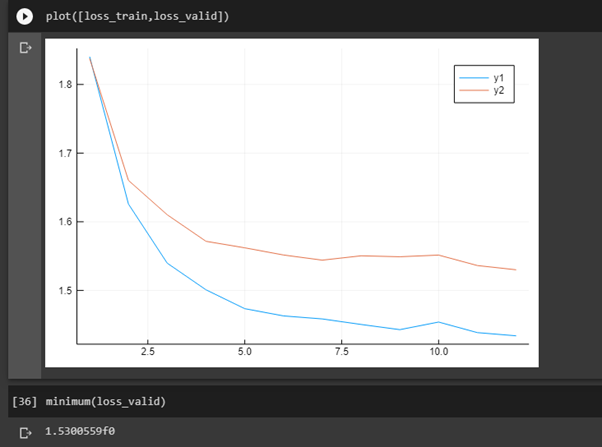

**3x Stacked LSTM recurrent units, with 128 input nodes each**


*   Lowest training loss of ≈1.36, but validation loss remained high implying overfitting.
*   Best training accuracy of 60% after 13 epochs.



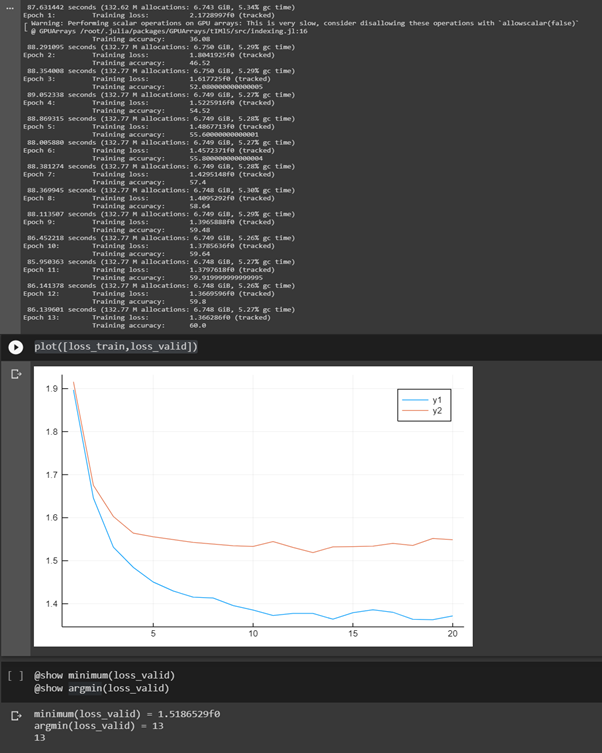

**1x LSTM & 1x GRU recurrent units, with 128 input nodes each.**

*   This model was seen to also be one of the best performers.
*   Best validation loss of ≈ 1.53.

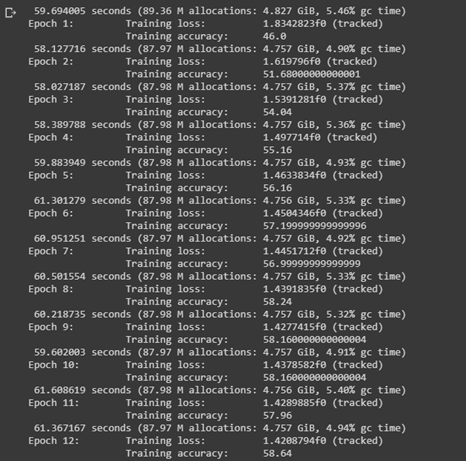




### 3: Train your final model to convergence on the training set using an optimisation algorithm of your choice.

In [ ]:
# A “stacked” LSTM, with two layers.
Stacked_LSTM_model = Chain(
    LSTM(length(outputs), 256),
    LSTM(256, 256),
    Dense(256, length(outputs)),
    softmax) |> gpu

function loss(xs, ys)
    l = mean(crossentropy.(Stacked_LSTM_model.(gpu.(xs)), gpu.(ys)))
    Flux.truncate!(Stacked_LSTM_model)
    l
end

# Very rough accuracy function
function accuracy(xs, ys)
  predictions    = Stacked_LSTM_model.(gpu.(xs))
  labels         = ys
  num_sentances  = length(predictions)
  num_characters = size(predictions[1])[2]
  c = 0

  for i in 1:num_sentances
    for j in 1:num_characters
      if argmax(predictions[i][:,j]) == findmax(labels[i][:,j])[2]
        c += 1
      end
    end
  end

  return (c/(num_sentances*num_characters))*100
end

optimiser = ADAM(0.01)

nothing

In [ ]:
loss_train = []
loss_valid = []

# Train for 15 epochs. The model seems to converge around this number.
# Any longer, the model seems to overfit the training data and perform worse & worse on the validation
@time for epoch in 1:15
    @time Flux.train!(loss, params(Stacked_LSTM_model), zip(trainxs, trainys), optimiser)
    append!(loss_train, loss(trainxs[1], trainys[1]).data)
    append!(loss_valid, loss(validxs[1], validys[1]).data)
    println("Epoch $(epoch):\t Training loss: \t $(loss(trainxs[1], trainys[1]))")
    println("\t \t Training accuracy: \t $(accuracy(trainxs[1], trainys[1]))")
    flush(stdout)
end

 54.303228 seconds (98.25 M allocations: 5.182 GiB, 4.56% gc time)
Epoch 1:	 Training loss: 	 1.8142742f0 (tracked)
	 	 Training accuracy: 	 45.72
 53.802481 seconds (98.33 M allocations: 5.187 GiB, 4.17% gc time)
Epoch 2:	 Training loss: 	 1.5561683f0 (tracked)
	 	 Training accuracy: 	 52.64
 53.990898 seconds (98.34 M allocations: 5.187 GiB, 4.49% gc time)
Epoch 3:	 Training loss: 	 1.4615715f0 (tracked)
	 	 Training accuracy: 	 56.52
 53.915522 seconds (98.33 M allocations: 5.187 GiB, 4.50% gc time)
Epoch 4:	 Training loss: 	 1.4058883f0 (tracked)
	 	 Training accuracy: 	 58.28
 53.457066 seconds (98.33 M allocations: 5.187 GiB, 4.16% gc time)
Epoch 5:	 Training loss: 	 1.3788589f0 (tracked)
	 	 Training accuracy: 	 59.31999999999999
 53.838630 seconds (98.34 M allocations: 5.188 GiB, 4.49% gc time)
Epoch 6:	 Training loss: 	 1.3667428f0 (tracked)
	 	 Training accuracy: 	 60.8
 53.834151 seconds (98.33 M allocations: 5.188 GiB, 4.48% gc time)
Epoch 7:	 Training loss: 	 1.3526759f0 (

### 4: Provide a plot of the loss on the training set and validation set for each epoch of training.

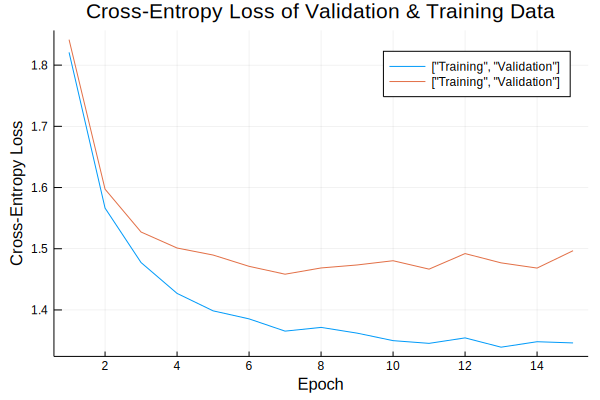

In [ ]:
plot([loss_train,loss_valid], labels=["Training","Validation"], xlab="Epoch", ylab="Cross-Entropy Loss", title="Cross-Entropy Loss of Validation & Training Data")

### 5: Provide the final accuracy on the training, validation, and test set.

In [ ]:
@show accuracy(trainxs[1], trainys[1])
@show accuracy(validxs[1], validys[1])
@show accuracy(testxs[1], testys[1])

nothing

accuracy(trainxs[1], trainys[1]) = 62.6
accuracy(validxs[1], validys[1]) = 55.64
accuracy(testxs[1], testys[1]) = 56.279999999999994


### 6: Provide 5 sentences completed by your final model, after you have provided a first few words.


In [ ]:
function sample(input, len)
    m = cpu(Stacked_LSTM_model)
    # Resets all internal states.
    Flux.reset!(m)
    buf = IOBuffer()
    # Prime the model with our initial input.
    for c in input[1:end - 1]
        m(onehot(c, outputs))
        write(buf, c)
    end
    write(buf, input[end])
    c = wsample(outputs, m(onehot(input[end], outputs)).data)
    write(buf, c)
    for i in 2:len
        c = wsample(outputs, m(onehot(c, outputs)).data)
        write(buf, c)
    end
    String(take!(buf))
end;

Inputting the words "The movie was " is seen to generate sentances:


*   "The movie was art"
*   "The movie was indulgen"
*   "The movie was seen and m"
*   "The movie was a genre th"








In [ ]:
sample("The movie was ", 10)

"The movie was a genre th"

Inputting the words "I found the acting to be " is seen to generate sentances:


*   "I found the acting to be flat"
*   "I found the acting to be once a"
*   "I found the acting to be struggle"
*   "I found the acting to be a bit in a"






In [ ]:
sample("I found the acting to be ", 10)

"I found the acting to be a bit in a"

Inputting the words "Disastrous, and most definitely not " is seen the generate sentances:


*   "Disastrous and most definitely not beyon"
*   "Disastrous and most definitely not because "
*   "Disastrous and most definitely not values at "
*   "Disastrous and most definitely not .There are predictab"





In [ ]:
sample("Disastrous and most definitely not ", 20)

"Disastrous and most definitely not .There are predictab"

Inputting the words "An amazing display of " is seen the generate sentances:


*   "An amazing display of Corpu"
*   "An amazing display of film , in "
*   "An amazing display of Cy ... and the "
*   "An amazing display of the kind of miscalcu"
*   "An amazing display of a poignay genred actors , The Animal Hivallet 's r"







In [ ]:
sample("An amazing display of ", 50)

"An amazing display of a poignay genred actors , The Animal Hivallet 's r"

Inputting the words "A mesmerising and brilliant display of " is seen the generate sentances:


*   "A mesmerising and brilliant display of Quirk"
*   "A mesmerising and brilliant display of the cinema"
*   "A mesmerising and brilliant display of exotic greatness .Ba"
*   "A mesmerising and brilliant display of the genuine looking pictures and viethab"
*   "A mesmerising and brilliant display of nothing cheap -- as it 's devoid on fun .For the real visuals of ` Lary 's cinem"







In [ ]:
sample("A mesmerising and brilliant display of ",80)

"A mesmerising and brilliant display of nothing cheap -- as it 's devoid on fun .For the real visuals of ` Lary 's cinem"